In [1]:
pathSave = 'data/'

%matplotlib inline
import os
#pathToDataset = '/home/optimus/AI/work/modal/CamVid/'
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['THEANO_FLAGS']='mode=FAST_RUN,device=gpu,floatX=float32,optimizer=fast_compile'
#os.environ['THEANO_FLAGS']='device=gpu,floatX=float32'
import cv2
from matplotlib import pyplot as plt
import numpy as np
np.random.seed(1337) # for reproducibility
from keras.layers.noise import GaussianNoise
import keras.models as models

from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D , UpSampling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.optimizers import *
from keras.layers.core import Dropout
from keras.layers.convolutional import ZeroPadding2D
from keras.layers import Input
from keras.layers.normalization import BatchNormalization
from keras.regularizers import ActivityRegularizer
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.models import load_model

from __future__ import absolute_import
import pylab as pl
import matplotlib.cm as cm
import itertools
import theano.tensor as T
np.random.seed(1337) # for reproducibility

from keras.layers.noise import GaussianNoise
import keras.models as models
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape, Merge, Permute
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.regularizers import ActivityRegularizer

from keras import backend as K

from cityscapes_labels import *
from shared_fonctions import *

Using Theano backend.
Using gpu device 0: GeForce GTX 960 (CNMeM is disabled, cuDNN not available)


In [2]:
# 8 classes
void = [0,0,0]
ground = [128,128,128]
construction = [192,128,128]
object2 = [128,128,192]
nature =[0,255,0]
sky = [0,0,255]
human = [255,0,0]
vehicle = [0,0,100]

classes_names = np.array(['void','ground','construction','object','nature','sky','human','vehicle'])
classes_colors = np.array([void,ground,construction,object2,nature,sky,human,vehicle])

appearance = np.array([ 0.08233421,  0.3969808 ,  0.22176062,  0.01898724,  0.1700346 ,
        0.03278272,  0.0072459 ,  0.06987391])
class_weighting = 1.0/appearance

# 35 classes

id_to_name = { label.id : label.name for label in labels}
id_to_color = { label.id : label.color for label in labels}

def get_name_class(i,nb):
    if(i==34):
        i=-1
    if(nb==8):
        return classes_names[i]
    else:
        return id_to_name[i]

def get_color_class(i,nb):
    if(i==34):
        i=-1
    if(nb==8):
        return classes_colors[i]
    else:
        return id_to_color[i]

appearance2 = np.array([  4.73161430e-05,   3.90454946e-02,   1.97589367e-04,
         1.25979764e-02,   9.26179702e-03,   4.15969376e-03,
         1.12470828e-02,   3.29785476e-01,   6.61101861e-02,
         1.90104167e-03,   8.22873975e-04,   2.01372382e-01,
         8.01898338e-03,   6.68616234e-03,   5.22896744e-04,
         5.04183743e-04,   4.96499317e-04,   1.08262893e-02,
         6.02587090e-04,   4.01546847e-03,   4.44451560e-03,
         1.52164874e-01,   6.35438012e-03,   3.76909011e-02,
         1.10954577e-02,   2.28910519e-03,   5.80620304e-02,
         1.00416951e-03,   1.40169627e-03,   4.04143898e-05,
         2.54937955e-04,   1.22181666e-02,   1.95319615e-03,
         2.80417520e-03,   0.00000000e+00])

class_weighting2 = np.sqrt(10/ (appearance+1e-4))


In [3]:
nb_classes = 8

In [4]:
class_weighting

array([  12.14561966,    2.51901351,    4.5093669 ,   52.66694896,
          5.88115595,   30.50387521,  138.009081  ,   14.31149337])

In [5]:
train_cities = os.listdir('cityscape/labels/train')
test_cities = os.listdir('cityscape/labels/test')

def binarylab(labels):
    labels = labels[:,:,0].reshape(240*480,1)
    x = np.zeros((240*480,nb_classes),dtype = np.int)    
    for i in range(240*480):
        x[i,labels[i,0]] = 1
    return x

path_img = 'small_cityscape/images/train/'
path_lbl = 'small_cityscape/labels/train/'

if(nb_classes !=8):
    path_lbl = 'small_cityscape/30_classes_labels/train/'

def load_cities(cities):
    img_city = []
    lbl_city = []
    for city in cities:
        for name in os.listdir(path_img+city+'/'):
            img_city.append(normalized(cv2.imread(path_img+city+'/'+name)))
            lbl_city.append(binarylab(cv2.imread(path_lbl+city+'/'+name)))
            #print '.',
        print city," ok"
    return np.array(img_city),np.array(lbl_city)


In [6]:
img_data = []
lbl_data = []

img_data,lbl_data = load_cities(train_cities[:5])



zurich  ok
erfurt  ok
bochum  ok
dusseldorf  ok
weimar  ok


In [7]:
img_data.shape

(690, 240, 480, 3)

res = np.zeros(35)
for i in range(122):
    print '.',
    res+= np.bincount([np.argmax(k) for k in lbl_data[i]],minlength = 35)

In [8]:
def create_encoding_layers():
    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2
    return [
        ZeroPadding2D(padding=(pad,pad),input_shape = (240,480,3)),
        Convolution2D(filter_size, kernel, kernel, border_mode='valid'),
        Activation('relu'),
        MaxPooling2D(pool_size=(pool_size, pool_size)),

        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(128, kernel, kernel, border_mode='valid'),
        
        Activation('relu'),
        MaxPooling2D(pool_size=(pool_size, pool_size)),

        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(256, kernel, kernel, border_mode='valid'),
       
        Activation('relu')
    ]

def create_decoding_layers():
    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2
    return [
        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(256, kernel, kernel, border_mode='valid'),
        

        UpSampling2D(size=(pool_size,pool_size)),
        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(128, kernel, kernel, border_mode='valid'),
        

        UpSampling2D(size=(pool_size,pool_size)),
        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(filter_size, kernel, kernel, border_mode='valid'),
        
    ]

autoencoder = models.Sequential()
# Add a noise layer to get a denoising autoencoder. This helps avoid overfitting

#autoencoder.add(GaussianNoise(sigma=0.3))
autoencoder.encoding_layers = create_encoding_layers()
autoencoder.decoding_layers = create_decoding_layers()
for l in autoencoder.encoding_layers:
    autoencoder.add(l)
for l in autoencoder.decoding_layers:
    autoencoder.add(l)

autoencoder.add(Convolution2D(nb_classes, 1, 1, border_mode='valid',))
autoencoder.add(Reshape((240*480,nb_classes)))
autoencoder.add(Activation('softmax'))
#from keras.optimizers import SGD
opt = SGD(lr=0.0000001, momentum=0.8, decay=1e-5, nesterov=True)
autoencoder.compile(loss="categorical_crossentropy", optimizer='adadelta',metrics=['categorical_accuracy'])

(Subtensor{int64}.0, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0, Subtensor{int64}.0)
(Subtensor{int64}.0, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0, Subtensor{int64}.0)
(Subtensor{int64}.0, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0, Subtensor{int64}.0)
(Subtensor{int64}.0, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0, Subtensor{int64}.0)
(Subtensor{int64}.0, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0, Subtensor{int64}.0)
(Subtensor{int64}.0, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0, Subtensor{int64}.0)


In [9]:
print autoencoder.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
zeropadding2d_1 (ZeroPadding2D)  (None, 242, 482, 3)   0           zeropadding2d_input_1[0][0]      
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 240, 480, 64)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 240, 480, 64)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 120, 240, 64)  0           activation_1[0][0]               
___________________________________________________________________________________________

In [12]:
from keras.callbacks import ModelCheckpoint
call = ModelCheckpoint('saved_models/autoencoder7cities20epochs.h5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15)
nb_epoch = 100
batch_size = 3

history = autoencoder.fit(img_data,lbl_data, nb_epoch = nb_epoch, batch_size = batch_size, verbose=1,class_weight=class_weighting,callbacks = [call,early_stopping],validation_split = 0.1)


Train on 621 samples, validate on 69 samples
Epoch 1/100
621/621 [==============================] - 233s - loss: 1.4262 - categorical_accuracy: 0.4899 - val_loss: 1.1522 - val_categorical_accuracy: 0.5731
Epoch 2/100
621/621 [==============================] - 232s - loss: 1.0871 - categorical_accuracy: 0.6240 - val_loss: 0.8319 - val_categorical_accuracy: 0.7264
Epoch 3/100
621/621 [==============================] - 232s - loss: 0.8730 - categorical_accuracy: 0.7145 - val_loss: 1.1012 - val_categorical_accuracy: 0.6447
Epoch 4/100
621/621 [==============================] - 232s - loss: 0.7877 - categorical_accuracy: 0.7464 - val_loss: 0.7072 - val_categorical_accuracy: 0.7784
Epoch 5/100
621/621 [==============================] - 232s - loss: 0.7326 - categorical_accuracy: 0.7662 - val_loss: 0.6169 - val_categorical_accuracy: 0.7992
Epoch 6/100
621/621 [==============================] - 232s - loss: 0.6864 - categorical_accuracy: 0.7810 - val_loss: 0.5911 - val_categorical_accuracy: 0.

In [13]:
autoencoder.save('saved_models/last_autoencoder.h5')
#autoencoder = load_model('saved_models/autoencoder.h5')

In [14]:
cities = ['strasbourg']

In [15]:
img_test, lbl_test = load_cities(cities)

strasbourg  ok


In [16]:
def model_evaluation():
    score = autoencoder.evaluate(img_test,lbl_test,batch_size = batch_size)
    print 'categorical accuracy',score[1]

In [65]:
def confusion_matrix(dataset,lbl):
    #true positive false negative false positive
    print dataset.shape
    res = np.zeros((8,8))
    # res[0] tp, 1 fn , 2 fp
    prediction = autoencoder.predict(dataset, batch_size = batch_size)
    for i in range(len(prediction)):
        print '.',
        for j in range(115200):
            pred_classe = np.argmax(prediction[i][j])
            true_classe = np.argmax(lbl[i][j])
            res[true_classe][pred_classe]+=1
    return res

def compute_score(tab):
    prec = np.zeros(nb_classes)
    rec = np.zeros(nb_classes)
    for i in range(nb_classes):
        tp = tab[i][i]
        fn = np.sum(tab[i])-tp
        fp = np.sum(tab[:,i])-tp
        print fn,fp,'--',
        prec[i] = tp/(tp+fp)
        rec[i] = tp/(tp+fn)
    print prec,rec
    return prec,rec
    

In [47]:
confm = confusion_matrix(img_test,lbl_test)

(365, 240, 480, 3)
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


In [64]:
confm[:,0]

array([ 3705687.,    75038.,    72658.,    14310.,    14053.,     4840.,
           9495.,    28567.])

In [66]:
prec,rec = compute_score(confm)
print np.mean(prec[:])
print np.mean(rec[:])
print np.mean(prec[1:])
print np.mean(rec[1:])

2103759.0 218961.0 -- 458054.0 2302445.0 -- 1176651.0 2654760.0 -- 579540.0 105407.0 -- 676414.0 584142.0 -- 159384.0 89789.0 -- 432240.0 97622.0 -- 993381.0 526297.0 -- [ 0.94420875  0.86993536  0.78525586  0.54981208  0.86580518  0.92244894
  0.62450044  0.74373753] [ 0.6378727   0.97111513  0.89189489  0.18175619  0.84783313  0.87014502
  0.27305385  0.60593036]
0.788213018495
0.659950158765
0.765927913349
0.663104081581


In [45]:
(0.94+0.80+0.73+0.77+0.15+0.43)/6

0.6366666666666666

In [17]:
model_evaluation()

365/365 [==============================] - 51s    
categorical accuracy 0.843525901723


In [18]:
def visualize(temp,nb_classes):
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(nb_classes):
        col = get_color_class(l,nb_classes)
        r[temp==l]=col[0]
        g[temp==l]=col[1]
        b[temp==l]=col[2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = (1.0*r/255.0)#[:,:,0]
    rgb[:,:,1] = (1.0*g/255.0)#[:,:,1]
    rgb[:,:,2] = (1.0*b/255.0)#[:,:,2]
    return rgb

def ref_colors():
    plt.figure()
    leg=np.array([[0,1,2,3],[4,5,6,7]])
    plt.imshow(visualize(leg,8), interpolation='none')
    l=classes_names
    plt.title(l[0]+', '+l[1]+', '+l[2]+', '+l[3]+', \n'+l[4]+', '+l[5]+', '+l[6]+', '+l[7])
    plt.plot()


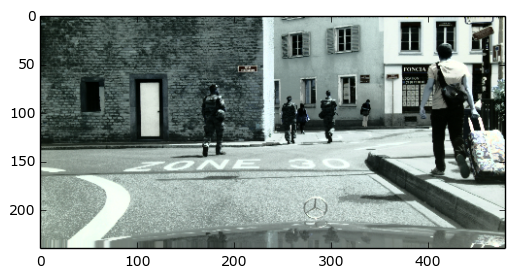

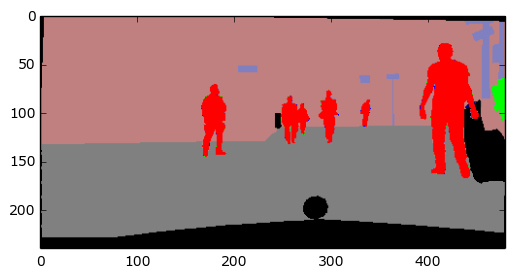

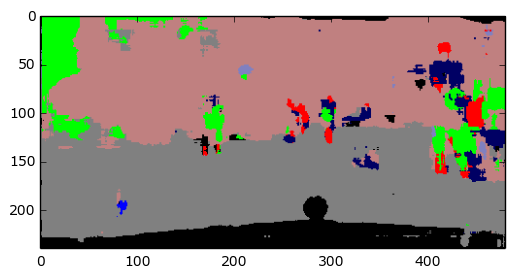

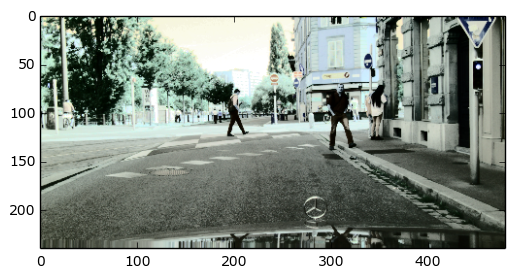

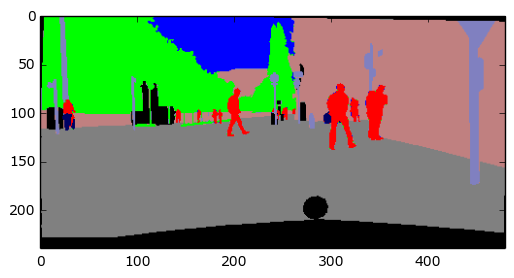

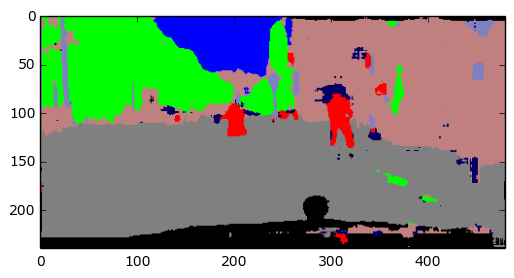

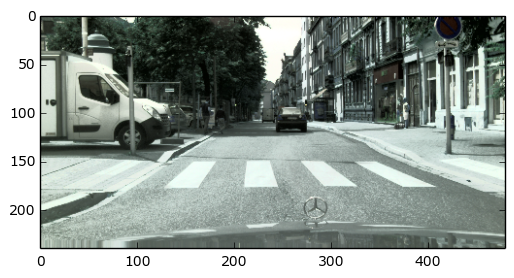

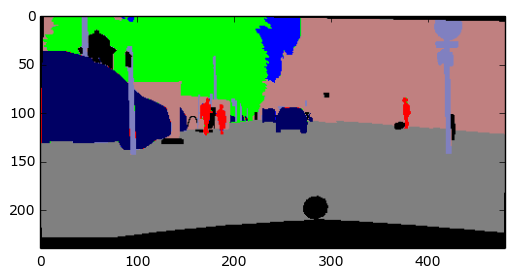

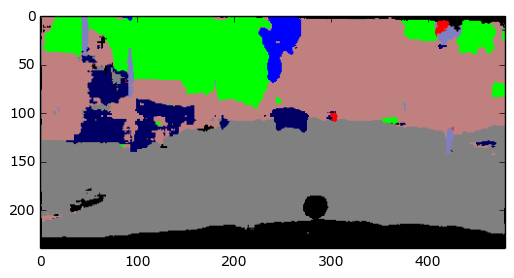

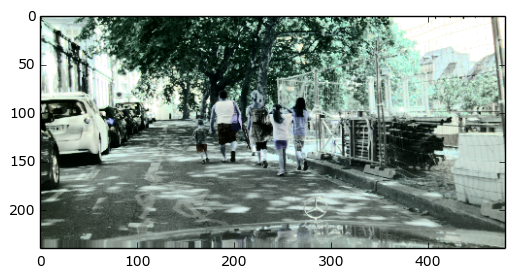

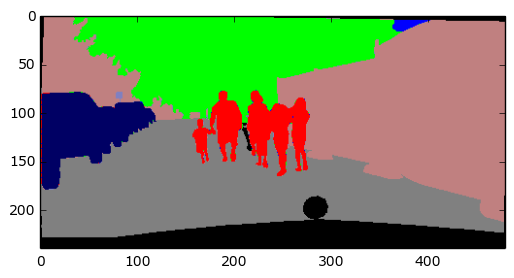

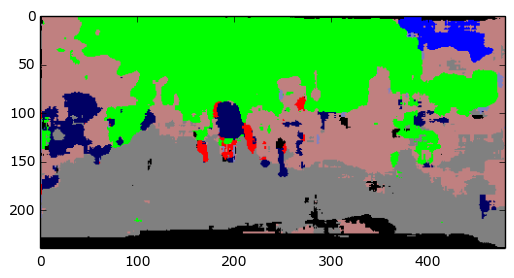

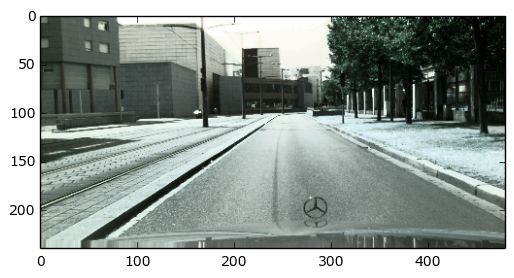

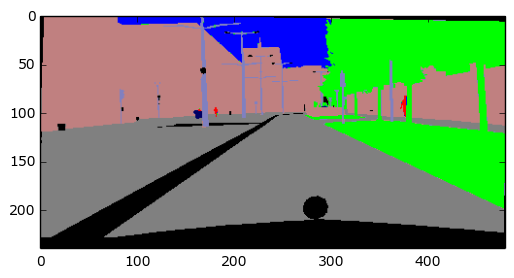

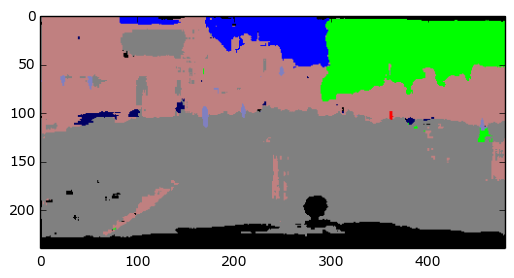

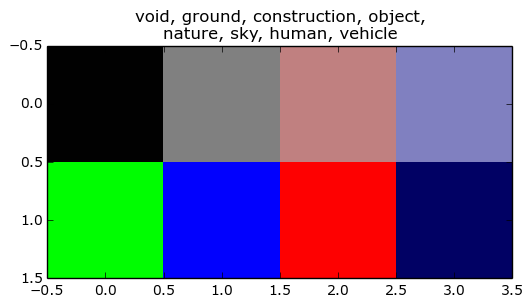

In [67]:
def restructure(lbl):
    tab = np.array([np.argmax(k) for k in lbl])
    tab = tab.reshape((240,480))
    return tab

def show_result(img,lbl):
    plt.figure()
    plt.imshow(img)
    plt.figure()
    plt.imshow(visualize(restructure(lbl),nb_classes))
    pred = autoencoder.predict(np.array([img]))
    plt.figure()
    plt.imshow(visualize(restructure(pred[0]),nb_classes))

pp=100
for i in range(pp,pp+5):
    show_result(img_test[i],lbl_test[i])

ref_colors()